<a href="https://colab.research.google.com/github/TrymSandven/Gruppeeksamen_2022/blob/main/group_exam22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Group Exam 2022 / INFO284 Machine Learning
Candidate numbers: 103, 168, 202, 161

### Introduction
We have been presented with a tabular data set containing 2833 albums including their covers in .png-format. The first task is to see if there are any correlation between the albums' popularity and properties of the adjoining tabular data  - e.g. tempo, energy levels, number of tracks, track duration, etc. These values are gathered and presented via Spotify's web API. The second task is creating a Convolutional Neural Network to research if the belonging album covers impact the popularity score. 

To start off, we will perform an introductary inspection of the data set, as such information tells us how we can preproccess its columns. An interesting remark concerning the data set, is that it only includes data about the first three songs of the albums. 

In [ ]:
# Data set 
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os, shutil
from keras.preprocessing import image

# ML Tools 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras import backend as K

import copy



We have used google colab when working with the tasks. The code is structured to run in colab, as seen here where we import the .csv-file. The other part of the code that is only able to run in colab, is in task B where we link to directory. If the code should be run in another IDE the only changes to be done is to change the path to directory and how to upload the files to the program. 

In [ ]:
# Import the .csv-file

from google.colab import files
 
uploaded = files.upload()

Saving albums.csv to albums.csv


In [ ]:
# Reads the .csv file and implements it to the dataframe.

df = pd.read_csv("albums.csv")

### Data Inspection

In [ ]:
# DataFrame.info() is used to retreive the dtpye index, column name, if the dtypes contain any
# null values and how the data type objects should be interpreted. The file's memory usage is also
# included at the bottom of the code cell.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2833 non-null   object 
 1   id            2833 non-null   int64  
 2   release_date  2833 non-null   object 
 3   artists       2833 non-null   object 
 4   total_tracks  2833 non-null   int64  
 5   t_name0       2833 non-null   object 
 6   t_name1       2833 non-null   object 
 7   t_name2       2833 non-null   object 
 8   t_dur0        2833 non-null   int64  
 9   t_dur1        2833 non-null   float64
 10  t_dur2        2833 non-null   float64
 11  t_dance0      2833 non-null   float64
 12  t_dance1      2833 non-null   float64
 13  t_dance2      2833 non-null   float64
 14  t_energy0     2833 non-null   float64
 15  t_energy1     2833 non-null   float64
 16  t_energy2     2833 non-null   float64
 17  t_key0        2833 non-null   float64
 18  t_key1        2833 non-null 

In [ ]:
# Checks if there exists null values in the data set. .sum() is needed for easy visualization,
# or else a same-sized object with the boolean values for each element is returned. 

df.isnull().sum()

name            0
id              0
release_date    0
artists         0
total_tracks    0
t_name0         0
t_name1         0
t_name2         0
t_dur0          0
t_dur1          0
t_dur2          0
t_dance0        0
t_dance1        0
t_dance2        0
t_energy0       0
t_energy1       0
t_energy2       0
t_key0          0
t_key1          0
t_key2          0
t_mode0         0
t_mode1         0
t_mode2         0
t_speech0       0
t_speech1       0
t_speech2       0
t_acous0        0
t_acous1        0
t_acous2        0
t_ins0          0
t_ins1          0
t_ins2          0
t_live0         0
t_live1         0
t_live2         0
t_val0          0
t_val1          0
t_val2          0
t_tempo0        0
t_tempo1        0
t_tempo2        0
t_sig0          0
t_sig1          0
t_sig2          0
popularity      0
dtype: int64

In [ ]:
# Display how many rows and columns the dataframe contains
df.shape

(2833, 45)

[35, 4, 6]


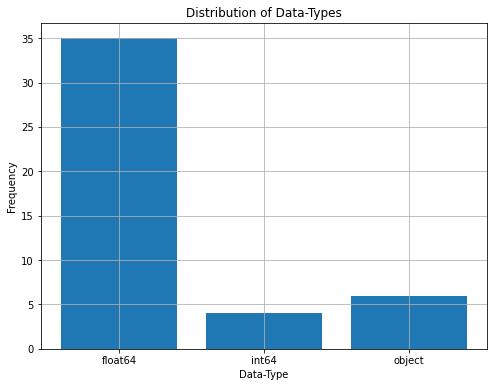

In [ ]:
# Visualization of dtypes
dtypes = df.dtypes
types = ['float64', 'int64', 'object']
list_dtypes = [0,0,0]

for dt in dtypes:
  if (str(dt) == 'float64'):
    list_dtypes[0] += 1
  elif (str(dt) == 'int64'):
        list_dtypes[1] += 1
  elif (str(dt) == 'object'):
        list_dtypes[2] += 1

print(list_dtypes)
plt.figure(figsize=(8, 6))
plt.bar(types, list_dtypes)
plt.title("Distribution of Data-Types")
plt.xlabel("Data-Type")
plt.ylabel("Frequency")
plt.grid()
plt.show()

This visulization shows the frequency of the dtypes.
The most common is float64.

### Preprocessing data

In [ ]:
# Finds the release years of the albums, and creates a new column 'year' with the content

def extract_year(date):
    year = date.split("-")[0]
    return int(year)

df['year'] = df['release_date'].apply(extract_year)

# Disincludes all songs that do not have a release year

df = df[df.year != 0]

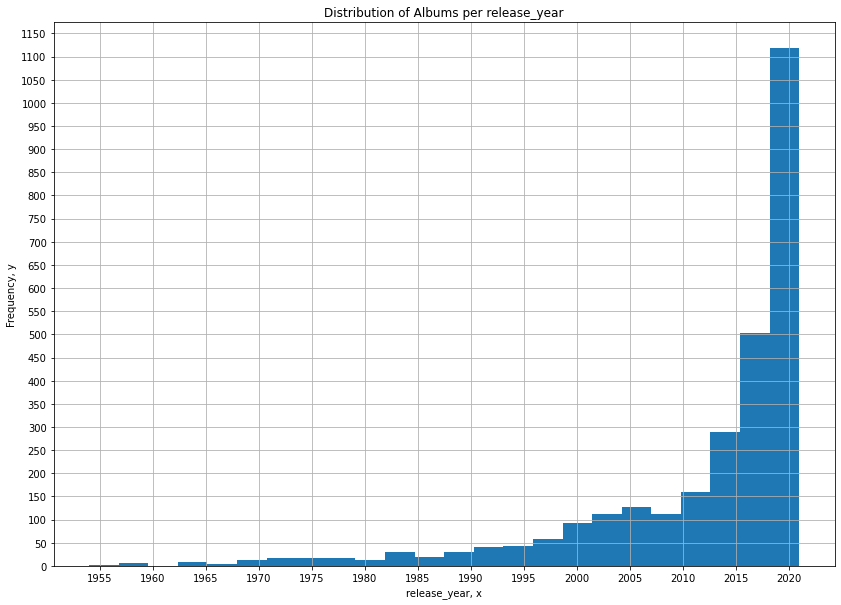

In [ ]:
# Visualization for release year

years = []
for y in df['year']:
  years.append(y)

years = pd.Series(years)
years = pd.Series([y for y in years if y != 0])

plt.figure(figsize=(14, 10))
plt.hist(years, bins = 24)
plt.locator_params(axis = "x", nbins = 24)
plt.locator_params(axis = "y", nbins = 24)
plt.title("Distribution of Albums per release_year")
plt.xlabel("release_year, x")
plt.ylabel("Frequency, y")
plt.grid()
plt.show()

Most of the songs in the data set are released after 1990.
Outliers before 1970 are removed to reduce noise.

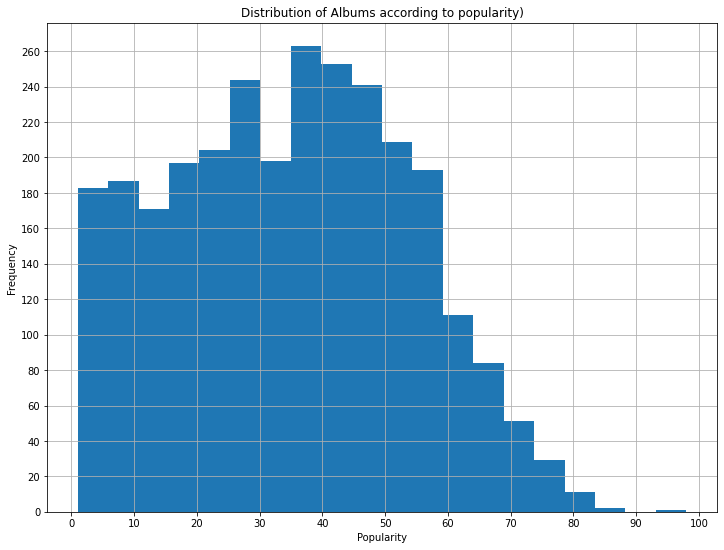

In [ ]:
plt.figure(figsize = (12, 9))
plt.hist(df['popularity'], bins = 20)
plt.locator_params(axis = "x", nbins = 20)
plt.locator_params(axis = "y", nbins = 20)
plt.title("Distribution of Albums according to popularity)")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.grid()
plt.show()

Visualization of the popularirty column shows few outliers after 85.
Due to limited data, albums with popularity below 90 are removed.

In [ ]:
# Removes outliers in the year column
year_copy = copy.copy(df.shape[0])

df = df[df.year > 1969]
df.shape
diff = year_copy-df.shape[0]
print(f'Removed {diff} outliers')

Removed 31 outliers


In [ ]:
# Removes outliers in the popularity column
pop_copy = copy.copy(df.shape[0])

df = df[df.popularity < 90]
df.shape
diff = pop_copy-df.shape[0]
print(f'Removed {diff} outliers')

Removed 1 outliers


In [ ]:
# Removes outliers in the total_tracks column
tot_copy = copy.copy(df.shape[0])

df = df[df.total_tracks < 99]
df.shape
diff = tot_copy-df.shape[0]
print(f'Removed {diff} outliers')

Removed 16 outliers


To reduce the risk of 'Exclusion bias' - that is e.g. removing to much data when correcting outliers - we were careful with not removing to many rows from these columns. 

In [ ]:
# Finds the length of the album's title, and creates a new column 'length_name' with the length

df['length_name'] = df['name'].apply(len)

In [ ]:
# Finds the mean of the chosen columns to reduce runtime in the models

def arithmetic_mean(track1, track2, track3):
    return (track1 + track2 + track3)/3

df['t_dur_mean'] = arithmetic_mean(df['t_dur0'], df['t_dur1'], df['t_dur2'])
df['t_dance_mean'] = arithmetic_mean(df['t_dance0'], df['t_dance1'], df['t_dance2'])
df['t_energy_mean'] = arithmetic_mean(df['t_energy0'], df['t_energy1'], df['t_energy2'])
df['t_speech_mean'] = arithmetic_mean(df['t_speech0'], df['t_speech1'], df['t_speech2'])
df['t_acous_mean'] = arithmetic_mean(df['t_acous0'], df['t_acous1'], df['t_acous2'])
df['t_live_mean'] = arithmetic_mean(df['t_live0'], df['t_live1'], df['t_live2'])
df['t_val_mean'] = arithmetic_mean(df['t_val0'], df['t_val1'], df['t_val2'])
df['t_tempo_mean'] = arithmetic_mean(df['t_tempo0'], df['t_tempo1'], df['t_tempo2'])

df = df.drop(['t_dur0', 't_dur1', 't_dur2', 't_dance0', 't_dance1', 't_dance2', 't_energy0', 't_energy1', 't_energy2', 't_speech0', 't_speech1', 't_speech2', 't_acous0', 't_acous1', 't_acous2', 't_live0', 't_live1', 't_live2', 't_val0', 't_val1', 't_val2', 't_tempo0', 't_tempo1', 't_tempo2'], axis=1)

The function finds the mean of relevant values in the dataset. The purpose is to make the models more efficient and reduce the runtime. The risk of doing this is that the dataset does not contain specific data of the songs, which can lead to lower accuracy when predicting popularity.

In [ ]:
# Drops columns that are deamed irrelevant or in string.
# id: id number was dropped since the model would have used it to check for popularity and the result would have been erroneus.
# release date: the date vary in different format, some with year format 'yyyy' and others with year and date e.g. 'yyyy-mm-dd'.
# The remaining columns are string values which cannot be used.

df.drop(columns = ['id', 'name', 'release_date', 'artists', 't_name0', 't_name1', 't_name2'], 
    inplace = True, axis = 1)

In [ ]:
# Sets 'max_columns' to None so that one can see all attributes to the albums.

pd.set_option('max_columns', None)
df.head(5)

,total_tracks,t_key0,t_key1,t_key2,t_mode0,t_mode1,t_mode2,t_ins0,t_ins1,t_ins2,t_sig0,t_sig1,t_sig2,popularity,year,length_name,t_dur_mean,t_dance_mean,t_energy_mean,t_speech_mean,t_acous_mean,t_live_mean,t_val_mean,t_tempo_mean
0,4,2.0,11.0,2.0,0.0,1.0,0.0,0.000000,0.000080,0.792000,4.0,3.0,4.0,21,2000,31,293071.000000,0.563667,0.426000,0.029633,0.503133,0.068700,0.353667,118.640000
1,12,4.0,11.0,9.0,1.0,0.0,1.0,0.000011,0.000225,0.000000,4.0,4.0,4.0,14,2011,20,213577.666667,0.663000,0.878667,0.120500,0.043793,0.085867,0.708333,142.758333
2,59,10.0,11.0,6.0,0.0,1.0,0.0,0.047100,0.000000,0.008280,4.0,4.0,4.0,41,2019,100,146673.333333,0.283667,0.976000,0.120167,0.090466,0.798000,0.240333,103.683000
3,8,7.0,8.0,11.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,4.0,4.0,4.0,1,2020,6,157071.666667,0.886333,0.713667,0.184267,0.189233,0.340000,0.553000,98.356333
4,17,5.0,5.0,5.0,1.0,0.0,0.0,0.000000,0.000000,0.000008,4.0,4.0,4.0,47,2018,12,216151.000000,0.766333,0.828333,0.060600,0.099600,0.121400,0.675000,132.007667


In [ ]:
# Sets popularity as 'target'.
target = df["popularity"] 

# Sets 'features' to dataset, with 'popularity' column subtracted.
features = df.drop("popularity", axis=1)

# Scales the data with MinMaxScaler.
# 'features' is scaled in the range of 0 to 1
scaler = MinMaxScaler()
scaler.fit(features)
features = scaler.transform(features)

# Splits the datset into training and test data.
X_train, X_test, y_train, y_test = train_test_split(features, target)

As per now, the data inspection uncovered that there are no null values in the columns. There were though several columns which included dtype objects (such as string and date). The columns name, release_date, artists and t_name[0:2] needed to be either edited or removed before splitting the data set into features and target. Id was removed because it would not have contributed to finding popularity, and would probably have made the result erroneus.

Instead of completely removing the column for date-year, we created a new column with only the release year. Month and day was removed because the format would vary from only year or american format(mm-dd-yyyy). Furthermore, finding outliers with the release year on its own will give a better visualization instead of using the complete date.

The length of the album name was included instead of the album name itself, so that the models would be able to interpret the data. Other columns with string value, such as artists and t_name was completely dropped. We also figured that predicting popularity based on the name of the first three songs in the album would be near impossible or give terrible readings. Predicting popularity based on the artists name was the only thing we could think of that would have given a better prediction. But to execute this, we would have to create a column based on the number of a given artist's spotify followers - using Spotify's REST API. Sadly, their API does not include a GET function for this, and using Crawlers/Spiders to retrieve this information violates no.5 in their user guideline (spotify.com). Including such a column would probably have been responsible for a significant increase in the models' test results. 

To further investigate the data set, we plotted bar graphs of the columns 'year', 'total tracks' and the target column 'popularity'. Visualizing these columns as bar plots, made it easy to remove outliers from the data set. Altogether, 48 outliers were removed including one outlier from 'popularity'. Removing more outliers from such a small data set could give worse result. The removed samples had an abnormally large distance from the rest of the test population. Removing these observations did not make a significant impact on the models' accuracy, but it is still conscidered a good custom - within the field of statistics and machine learning - to have 'noise' removed.

###Models

We ended up using the models Ridge, support vector regressor (SVR), random forrest regressor and Multilayer perceptron (MLP). On all of these we used grid search to find the best parameters and cross-validation. With cross-validation we eliminate the randomness of being “lucky” or “unlucky” with where we split the data. We also end up using the data more effectively. When using the normal test_train_split we end up using 75% to train the model and 25% to test it. When using cross-validation with five-fold we end up using four-fifths (80%) in each iteration and nine-tenths (90%) when using ten-fold.

The main disadvantage to cross validation is the increase in computational cost. When using cross-validation the duration to train the model is the time it takes to train a single model times the number of folds made.


In [ ]:
# Dict used for printing out the different model's best score

best_score = dict()

### Ridge model
Ridge regression is linear regression model, which uses the same formula as the ordinary least squares model, but with a built-in restriction in form of a constraint to avoid overfitting. It does this by applying the consept of regularization, more specifically L2 regularization. This can, in practice, give a lower training set score than normal least squares linear regression. On the other hand, it can also give a higher test set score, which happens due to the built-in constraint that prevents overfitting. In turn, this can lay the groundwork for better generalization and is especially true for smaller subsets of data, since least squares linear regression eventually will catch up to the Ridge model if more data is introduced (Müller and Guido, 2017, 51-55).


In [ ]:
# finds the optimale alpha value with 'grid search'
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

# trains the Ridge model on the dataset using gridsearch and CV
t0 = time.time()
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring=scoring, refit='r2', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)
t1 = time.time()

def Average(lst):
    return sum(lst) / len(lst)

r2_train = grid.cv_results_['mean_train_r2']
r2_test = grid.cv_results_['mean_test_r2']
absolute = grid.cv_results_['mean_test_neg_mean_absolute_error']
squared = grid.cv_results_['mean_test_neg_root_mean_squared_error']


print('Best Score: ', grid_result.best_score_)
print('Avrage r2 score on train data', Average(r2_train))
print('Avrage r2 score on test data', Average(r2_test))
print('Negative mean absolute error', Average(absolute))
print('Negative root mean squared error: ', Average(squared))
print('Best Params: ', grid_result.best_params_)
print('Time taken: ', round(t1-t0, 3))
best_score['ridge'] = grid_result.best_score_

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.08551457729243223
Avrage r2 score on train data 0.09246241309106991
Avrage r2 score on test data 0.07019100721073891
Negative mean absolute error -15.177330656672885
Negative root mean squared error:  -18.335580863609692
Best Params:  {'alpha': 1}
Time taken:  0.374


### SVR (Support Vector Regression)

This model is based on the principles of Support vector machines, which uses different datapoints in the training process to define a “decision boundary”. This decision boundary is a boundary between the different classes, and together with support vectors, classifies the datapoints. The classification decision is based on the distance between the decision boundary and these support vectors. This model can work well on both low-dimensional and high-dimensional data, but requires, on the other hand, careful preprocessing of the data. For this reason, tree-based models are more popular due to an easier preprocessing (Müller and Guido, 2017, 100-106).

SVR gives us the flexibility to define how much error is acceptable in our model and will find an appropriate line (or hyperplane in higher dimensions) to fit the data. The error term is  handled in the constraints, where we set the absolute error less than or equal to a specified margin, called the maximum error or epsilon. We can tune epsilon to gain the desired accuracy of our model (Sayad, 2022).

In [ ]:
# trains the SVR model with 'Grid Search' and 'Cross Validation'
# 'Grid Search' is used to find the best values fr 'gamma' and 'C'
svm = SVR()
param_grid = {'gamma': [0.01, 0.1, 0.5], 'C': [1, 10, 15], 'epsilon': [0.1, 0.5, 1.0, 1.5]}
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

t0 = time.time()
grid = GridSearchCV(estimator=svm, param_grid=param_grid, scoring=scoring, refit='r2', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)
t1 = time.time()

def Average(lst):
    return sum(lst) / len(lst)

r2_train = grid.cv_results_['mean_train_r2']
r2_test = grid.cv_results_['mean_test_r2']
absolute = grid.cv_results_['mean_test_neg_mean_absolute_error']
squared = grid.cv_results_['mean_test_neg_root_mean_squared_error']


print('Best Score: ', grid_result.best_score_)
print('Avrage r2 score on train data', Average(r2_train))
print('Avrage r2 score on test data', Average(r2_test))
print('Negative mean absolute error', Average(absolute))
print('Negative root mean squared error: ', Average(squared))
print('Best Params: ', grid_result.best_params_)
print('Time taken: ', round(t1-t0, 3))
best_score['svm'] = grid_result.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best Score:  0.09654027417055963
Avrage r2 score on train data 0.1331865703232892
Avrage r2 score on test data 0.06723254155102837
Negative mean absolute error -15.1924551332684
Negative root mean squared error:  -18.36430457150434
Best Params:  {'C': 15, 'epsilon': 0.5, 'gamma': 0.1}
Time taken:  172.27


### Random Forest Regressor

Random forest regressor is an ensemble method which uses decision trees as a building block for its model. It is essentially a collection of decision trees, which makes it counteract a main drawback of the decision tree model. This drawback is the tendency to overfit the training data, which the Random forest regressor model addresses. It does so by creating a collection of random trees, which are all slightly different from each other, and where most of them likely overfit the data in different ways. Then, it reduces the amount of overfitting by averaging all the results from the trees in the collection, while still retaining predicting power (Müller and Guido, 2017, 85). To ensure this work effectively, the decision trees that make up the collection need to make diverse predictions and aggregate these for a probabilistic prediction (Pool and Mackworth, 2017, 317-318). 

In [ ]:
# trains the RandomForestRegressor model and uses 'Grid Search' to find the best values for 'max_depth' and 'n_estimators'
rfr = RandomForestRegressor()
param_grid = {'max_depth': [None, 1, 2], 'n_estimators': [50, 100, 150], 'criterion': ['squared_error'], 'random_state': [10]}
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

t0 = time.time()
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring=scoring, refit='r2', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)
t1 = time.time()

def Average(lst):
    return sum(lst) / len(lst)

r2_train = grid.cv_results_['mean_train_r2']
r2_test = grid.cv_results_['mean_test_r2']
absolute = grid.cv_results_['mean_test_neg_mean_absolute_error']
squared = grid.cv_results_['mean_test_neg_root_mean_squared_error']


print('Best Score: ', grid_result.best_score_)
print('Avrage r2 score on train data', Average(r2_train))
print('Avrage r2 score on test data', Average(r2_test))
print('Negative mean absolute error', Average(absolute))
print('Negative root mean squared error: ', Average(squared))
print('Best Params: ', grid_result.best_params_)
print('Time taken: ', round(t1-t0, 3))
best_score['rfr'] = grid_result.best_score_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Score:  0.16486441722318065
Avrage r2 score on train data 0.35554162026771546
Avrage r2 score on test data 0.10400532990587148
Negative mean absolute error -14.834675282020394
Negative root mean squared error:  -18.000342904918366
Best Params:  {'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 150, 'random_state': 10}
Time taken:  65.974


### MLP Regressor

Multilayer perceptron (MLP) is a relatively simple model within neural networks which can be used for both classification and regression. The model is built up of nodes which are connected by lines that represent learned coefficients or «weights». There are nodes that represent input, output, and nodes in-between these. When data is introduced to the model, it will process it through the nodes in the stages mentioned above to make a decision (Müller and Guido, 2017, 106-108). It is an effective model that has good potential, and by tuning parametres and giving enough computation time, it can often outperform other machine learning models when it comes to classification and regression. On the other hand, it can take a long time to train and adjust, especially if the neural network is large. It also requires a careful preprocessing of data in the preparation stages, as it is works best with data that has features with similar meanings (Müller and Guido, 2017, 119-120).

In [ ]:
regr = MLPRegressor()

param_grid = {'max_iter':[500, 1000, 1500], "hidden_layer_sizes": [(1,),(5,),(10,)], "activation": ['relu'], "solver": ['sgd'], 'learning_rate':['constant'], "alpha": [0.0005, 0.0075, 0.01, 0.05], 'random_state': [10]}
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

t0 = time.time()
grid = GridSearchCV(estimator=regr, param_grid=param_grid, scoring=scoring, refit='r2', return_train_score=True, verbose=1, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)
t1 = time.time()

def Average(lst):
    return sum(lst) / len(lst)

r2_train = grid.cv_results_['mean_train_r2']
r2_test = grid.cv_results_['mean_test_r2']
absolute = grid.cv_results_['mean_test_neg_mean_absolute_error']
squared = grid.cv_results_['mean_test_neg_root_mean_squared_error']


print('Best Score: ', grid_result.best_score_)
print('Avrage r2 score on train data', Average(r2_train))
print('Avrage r2 score on test data', Average(r2_test))
print('Negative mean absolute error', Average(absolute))
print('Negative root mean squared error: ', Average(squared))
print('Best Params: ', grid_result.best_params_)
print('Time taken: ', round(t1-t0, 3))
best_score['regr'] = grid_result.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score:  0.10783633890384162
Avrage r2 score on train data 0.12197272135881097
Avrage r2 score on test data 0.08612534614899497
Negative mean absolute error -15.01461848242516
Negative root mean squared error:  -18.21602618821639
Best Params:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 10, 'solver': 'sgd'}
Time taken:  69.589


### Performance Analysis of Models


In [ ]:
#prints the best results from the different models
for items in best_score.items():
  print(items)

('ridge', 0.08551457729243223)
('svm', 0.09654027417055963)
('rfr', 0.16486441722318065)
('regr', 0.10783633890384162)


Gridsearch Cross-Validation was implemented into all the models so that the best combination of 
parameters were outputted. The only disadvantage of this method is that the outputted .best_params_ 
(best parameters) are the 'best' that could be produced from the given parameter grid. 

All the models performed badly, even with different Gridsearch parameters. The obvious best performance 
is that of  Random Forest Regressor (RFR). Still, the outcome is far from satisfactory to be able to claim 
that popularity can be predicted from the adjoining columns. The susptected reason for this is due to 
'sample bias'. First of all, our data set is a subset of a much larger data set found on kaggle.com (Kaggle, 2021). Second, our data set only contains the first three songs in the albums. The songs that increase 
an album's popularity is not necessarily one of the first three songs.

Furthermore, most of our models seem to be suffering from overfitting. When looking at the discrepancy between the average training and test scores the training score is usually significantly higher. Our hypothesis is that the amount of noise in the dataset affects the models negatively. Meaning that the random fluctuations in the training data is being learned by the models. The one outlier is ridge which does not suffer as much as the rest. This has most likely to do with ridge’s built-in overfitting restraints


# Task B, Convolutional Neural Network

In this task we will build a convolutional neural network model to predict four featuers from the tabular data used in task A. The features we have chosen to predict are popularity, release year, length of album name and total tracks on the album. We will use a pre-trained convolutional neural
network in our model, to help predict the features. First, we need to do some preprocessing of the data to fit our needs.

# Preprocessing

In [ ]:
# Sorts dataframe by id number
df = pd.read_csv("albums.csv")
df = df.sort_values(by='id')



Here we read the tabular data to a dataframe called df, and sort that dataframe by id number. We sort it by id because this help us add the images to the dataframe later on. 

In [ ]:
# Mounts google drive where the images are stored
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


When working with the neural network and the images, we decided it was easiest for us to use the google colab. The easiest way of importing the images was by uploading the images to google drive and mount the drive to google colab. This way we granted access to the images in the same way as if we were working with the images locally. 

In [ ]:
!unzip -u "/content/drive/My Drive/transfer_214269_files_c42cff32.zip" -d "/content/drive/My Drive/images_INFO284"

In [ ]:
!unzip -u "/content/drive/My Drive/images_INFO284/images.zip" -d "/content/drive/My Drive/images_INFO284/IMAGES"

The files we downloaded from the assisgnment text were in a zip file. We uploaded this file to google drive. Here we unzip the file "transfer_214269_files_c42cff32.zip" to a folder "images_INFO284" on the drive. Then we unzip the image file to a folder "IMAGES". The filepath to the images ended up being "/content/drive/My Drive/images_INFO284/IMAGES/images".

In [ ]:
# Adds all imagepaths to a list

images_unsorted = []
base_dir = "/content/drive/My Drive/images_INFO284/IMAGES/images"
for filename in os.listdir(base_dir):
    img = os.path.join(base_dir, filename)
    images_unsorted.append((int(filename.split('.')[0]), img))

We want to connect the images to the dataframe. The target here is to make a new column in the dataframe with all the imagepaths, so that the imagepath is connected to the right album. The filenames to the cover images is the same as the id number, so we make a list of tuples where the first instance in the tuple is the id number and the second instance of the tuple are the filepath to the image. 

In [ ]:
# Sorts by id number
images_unsorted.sort(key=lambda tup: tup[0])
images = []
for image in images_unsorted:
  images.append(image[1])


Here we sort the images after id number, and then adds only the filepath to a new list. This way we get a list with all the filepaths sorted by id number which we can add to the dataframe.

In [ ]:
# Adds the file path for the album cover to the dataframe
df['Image'] = images
df.head(3)

,name,id,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,...,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity,Image
1554,Nibiru,1,2019-11-29,"Ozuna,",18,Nibiru,Hasta Que Salga el Sol,Temporal,158826,188480.0,...,0.598,0.484,173.023,96.042,148.019,4.0,4.0,4.0,67,/content/drive/My Drive/images_INFO284/IMAGES/...
443,Club Future Nostalgia (DJ Mix),15,2020-08-28,"Dua Lipa, The Blessed Madonna,",17,Future Nostalgia (Joe Goddard Remix) [Mixed],Cool (Jayda G Remix) [Mixed],Good In Bed (Zach Witness & Gen Hoshino Remixe...,174240,126373.0,...,0.648,0.379,122.978,122.913,93.888,4.0,4.0,4.0,56,/content/drive/My Drive/images_INFO284/IMAGES/...
458,"Come Over When You're Sober, Pt. 2",21,2018-11-09,"Lil Peep,",13,Broken Smile (My All),Runaway,Sex with My Ex,280520,192760.0,...,0.175,0.470,120.044,79.892,167.892,4.0,3.0,4.0,77,/content/drive/My Drive/images_INFO284/IMAGES/...


As we can see on the first three rows in the dataframe, the imagepaths has been added to each album. 

In [ ]:
#Preprocessing
df['year'] = df['release_date'].apply(extract_year)

# Disincludes all songs that do not have a release year

df = df[df.year != 0]

# Removes outliers that were released before 1969
df = df[df.year > 1969]

# Removes outliers that are more popular than 90
df = df[df.popularity < 90]

# Removes outliers that includes more tracks than 99
df = df[df.total_tracks < 99]

# Adds a column with the name length
df['length_name'] = df['name'].apply(len)

# Calculates the mean of some chosen features
df['t_dur_mean'] = arithmetic_mean(df['t_dur0'], df['t_dur1'], df['t_dur2'])
df['t_dance_mean'] = arithmetic_mean(df['t_dance0'], df['t_dance1'], df['t_dance2'])
df['t_energy_mean'] = arithmetic_mean(df['t_energy0'], df['t_energy1'], df['t_energy2'])
df['t_speech_mean'] = arithmetic_mean(df['t_speech0'], df['t_speech1'], df['t_speech2'])
df['t_acous_mean'] = arithmetic_mean(df['t_acous0'], df['t_acous1'], df['t_acous2'])
df['t_live_mean'] = arithmetic_mean(df['t_live0'], df['t_live1'], df['t_live2'])
df['t_val_mean'] = arithmetic_mean(df['t_val0'], df['t_val1'], df['t_val2'])
df['t_tempo_mean'] = arithmetic_mean(df['t_tempo0'], df['t_tempo1'], df['t_tempo2'])

# Drops the features which we have calculated the mean.
df = df.drop(['t_dur0', 't_dur1', 't_dur2', 't_dance0', 't_dance1', 't_dance2', 't_energy0', 't_energy1', 't_energy2', 't_speech0', 't_speech1', 't_speech2', 't_acous0', 't_acous1', 't_acous2', 't_live0', 't_live1', 't_live2', 't_val0', 't_val1', 't_val2', 't_tempo0', 't_tempo1', 't_tempo2'], axis=1)

# Stores an unscaled column of the four features we want to predict. (to be used later on)
popularity = df['popularity']
year = df['year']
length = df['length_name']
total_tracks = df['total_tracks']

# Scales the numerical columns
num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Stores a scaled column of the four features we want to predict.(to be used later on)
scaled_pop = df['popularity']
scaled_year = df['year']
scaled_length = df['length_name']
scaled_tracks = df['total_tracks']


Now we do the same preprocessing as we did in task A. We store unscaled and scaled versions of the four features we want to predict. This makes it easier to adapt the dataframe when we will predict a different feature. When we predict one of the features, we want the target value to be unscaled. This is because we want to predict unscaled values. 

# Predict Popularity

First we will make a model to predict popularity of the albums. Our hypothesis is that the album cover does not influence the popularity in a significant way. Thus, we think the model will not perform well. 

In [ ]:
# Uses the unscaled version of popularity
df['popularity'] = popularity

In [ ]:
len(df)

2784

"Fragtime" Theme Song "Fragile"


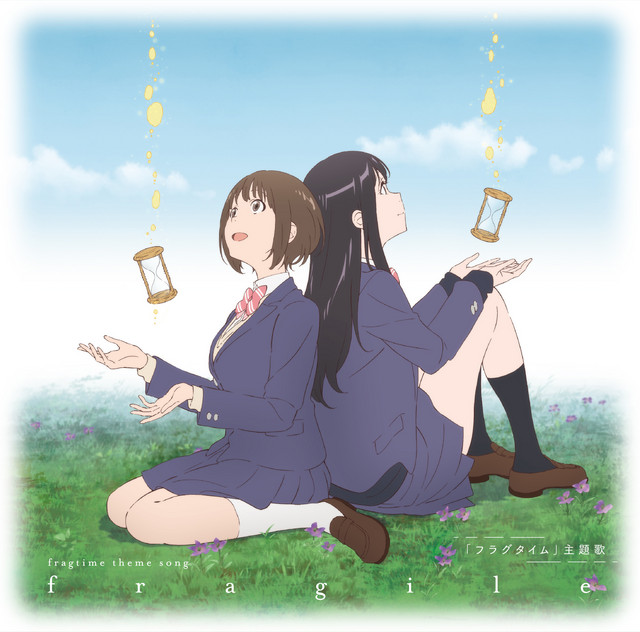

In [ ]:
from PIL import Image
img = Image.open(df['Image'][0])
print(df['name'][0])
display(img)

We display the first name and the first image in the dataframe to test that these two matches each other. Here we can see that the first album cover is the right cover for the album name.

In [ ]:
# Make two new directories called 'train' and 'test'
base_dir = "/content/drive/My Drive/images_INFO284/IMAGES"
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
# Split the images in training and test set.
for image in df['Image'][:(len(df)//4)*3]:
  src = image
  dst = os.path.join(train_dir, image.split("/")[-1])
  shutil.copyfile(src, dst)

for image in df['Image'][(len(df)//4)*3:]:
  src = image
  dst = os.path.join(test_dir, image.split("/")[-1])
  shutil.copyfile(src, dst)


We split the images into training and test set where 75 % of the images are put in the training directory, and 25 % are put in the test directory.

In [ ]:
print('total training images:', len(os.listdir(train_dir)))
print('total test images:', len(os.listdir(test_dir)))

total training images: 2088
total test images: 696


In [ ]:
# Split the dataframe into a training dataframe and a test dataframe
train_df = df[:(len(df)//4)*3]
test_df = df[(len(df)//4)*3:]

We also need to split the dataframe into a training dataframe and a test dataframe. The train_df contains the same albums as the training directory, and the test_df contains the same albums as the test directory. 

In [ ]:
print("train_df length:", len(train_df))
print("test_df length:", len(test_df))

train_df length: 2088
test_df length: 696


In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=None,
  x_col="Image",
  y_col="popularity",
  subset="training",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= None,
  x_col="Image",
  y_col="popularity",
  subset="validation",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory= None,
  x_col="Image",
  y_col=None,
  batch_size=29,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(150,150))

Found 1566 validated image filenames.
Found 522 validated image filenames.
Found 696 validated image filenames.


We use the flow_from_dataframe method to make the generators. The training set are split into a training set and a validation set. The dataframe are set to train_df for train_generator and validation_generator, and are set to test_df for test_generator. We split the dataframe so that we can test the model on a set of data that has not been used in the training. 

Since we use the full filepaths on the images we do not need to specify the directory. Then we set X column on the feature we want train on, which in our task is the images, and y column to the feature we want to predict, which in this case is popularity. 

Batch size is set to 29 because the size of the generator is divisible by 29 in all three of the generators. 

Since we are doing a regression task the class mode are set to raw.

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

As in task A, we want to use R squared metrics on the model. Keras does not have this as a implemented metrics, so we defined a function that calculates the R squared. 
source: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/

In [ ]:
model = Sequential()
model.add(VGG19(include_top=False, weights='imagenet', input_shape=(150, 150, 3)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation=None))
model.compile(optimizer = Adam(lr=1e-3, decay=1e-3 / 200),loss="mean_absolute_error",metrics=[RootMeanSquaredError(), coeff_determination])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Then we initate the CNN-model. We use the VGG19 in our model. It is a pre-trained model which has a depth of 19 layers, and was built and trained at the University of Oxford in 2014. We add two outputlayers that fit our target. 

When compiling the model we use the Adam optimizer. The metrics we use are mean absolute error, root mean squared error and R squared. We also used these three metrics in task A, which make it easier for us to compare the results. 

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
54/54 [==============================] - 103s 708ms/step - loss: 74.9972 - root_mean_squared_error: 403.3165 - coeff_determination: -741.1229 - val_loss: 18.2401 - val_root_mean_squared_error: 21.6221 - val_coeff_determination: -0.1702
Epoch 2/10
54/54 [==============================] - 35s 650ms/step - loss: 15.2771 - root_mean_squared_error: 18.2618 - coeff_determination: -0.0886 - val_loss: 19.8782 - val_root_mean_squared_error: 23.5641 - val_coeff_determination: -0.3621
Epoch 3/10
54/54 [==============================] - 35s 642ms/step - loss: 15.4008 - root_mean_squared_error: 18.3894 - coeff_determination: -0.1118 - val_loss: 18.0325 - val_root_mean_squared_error: 21.3927 - val_coeff_determination: -0.1277
Epoch 4/10
54/54 [==============================] - 35s 642ms/step - loss: 15.5873 - root_mean_squared_error: 18.6085 - coeff_determination: -0.1308 - val_loss: 20.5018 - val_root_mean_squared_error: 24.2984 - val_coeff_determination: -0.4111
Epoch 5/10
54/54 [======

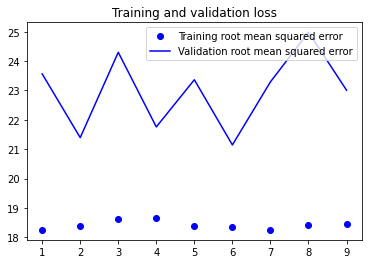

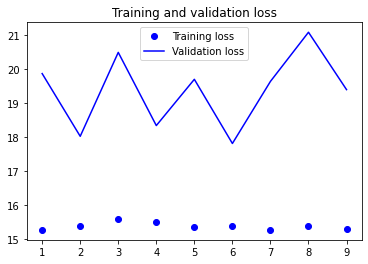

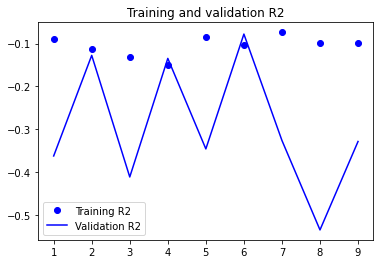

In [ ]:
rmse = history.history['root_mean_squared_error'][1:]
val_rmse = history.history['val_root_mean_squared_error'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
r2 = history.history['coeff_determination'][1:]
val_r2 = history.history['val_coeff_determination'][1:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, rmse, 'bo', label='Training root mean squared error')
plt.plot(epochs, val_rmse, 'b', label='Validation root mean squared error')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.plot(epochs, r2, 'bo', label='Training R2')
plt.plot(epochs, val_r2, 'b', label='Validation R2')
plt.title('Training and validation R2')
plt.legend()
plt.show()

When plotting the result here, we do not include the first epoch, because it differs much from the rest. The visualizing gives more information if we remove it. In task A the best models had a mean absolute error (MAE) of just below 15, and the CNN has a MAE of just above 15. The root mean squared error results are also similar, with an average standard deviation of approximatiley 18. The R squared score are below 0, which are telling us that the model is no better than one that consistently predicts the average of the target feature. 

The tendency that the validation loss is greater than training loss suggests that the model is overfitted. The dataset is not that big, which could lead to a high variance. The amount of noise is also affecting the model negatively. 

In [ ]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[19.40614128112793, 23.008628845214844, -0.2991877794265747]

In [ ]:
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

24/24 [==============================] - 12s 495ms/step


In [ ]:
test_df['prediction_popularity'] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Then we test the model, and add the results to the test dataframe. 

In [ ]:
test_df[['popularity', 'prediction_popularity']]

,popularity,prediction_popularity
2324,18,34.350410
567,47,34.289116
1764,27,34.285503
1888,53,34.331371
1615,26,34.268814
...,...,...
1156,20,34.307926
2592,47,34.279617
1695,35,34.284168
1069,4,34.332771


In [ ]:
print('minimum popularity predicted: ', test_df['prediction_popularity'].min())
print('maximum popularity predicted: ', test_df['prediction_popularity'].max())

minimum popularity predicted:  34.265625
maximum popularity predicted:  34.51169967651367


The prediction varies very little. It seems like the model does not see any correlation between the album covers and the popularity. It is likely that the model found a value that minimizes the mean absolute error, a kind of average of the popularity. The model predicts popularity to a little above 34, which means that this must be a value that the model thinks have the best chance to be close to the actual value. 

# Predict release year

Next we will use the model to predict release year. 

In [ ]:
df['year'] = year
df['popularity'] = scaled_pop

We set the year column to unscaled, since this is the feature we want to predict. Then we scale the popularity column. 

In [ ]:
train_df = df[:(len(df)//4)*3]
test_df = df[(len(df)//4)*3:]

The train dataframe and test dataframe need to be initialized again since two of the columns have been changed.

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=None,
  x_col="Image",
  y_col="year",
  subset="training",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= None,
  x_col="Image",
  y_col="year",
  subset="validation",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory= None,
  x_col="Image",
  y_col=None,
  batch_size=29,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(150,150))

Found 1566 validated image filenames.
Found 522 validated image filenames.
Found 696 validated image filenames.


Here we prepare the generators. The only changes from the earlier generators are the y column, which we set to 'year'. This is because this is the feature we want to predict.

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
54/54 [==============================] - 36s 664ms/step - loss: 4500.7964 - root_mean_squared_error: 18329.0410 - coeff_determination: -3048885.7500 - val_loss: 2012.2675 - val_root_mean_squared_error: 2012.2948 - val_coeff_determination: -44844.2930
Epoch 2/10
54/54 [==============================] - 35s 654ms/step - loss: 1803.4286 - root_mean_squared_error: 2553.6040 - coeff_determination: -68015.3594 - val_loss: 527.5442 - val_root_mean_squared_error: 527.6476 - val_coeff_determination: -3240.6802
Epoch 3/10
54/54 [==============================] - 35s 651ms/step - loss: 466.8267 - root_mean_squared_error: 662.9276 - coeff_determination: -5586.3223 - val_loss: 63.5299 - val_root_mean_squared_error: 64.3833 - val_coeff_determination: -42.8387
Epoch 4/10
54/54 [==============================] - 35s 646ms/step - loss: 230.0162 - root_mean_squared_error: 286.4142 - coeff_determination: -964.4789 - val_loss: 53.3399 - val_root_mean_squared_error: 54.3535 - val_coeff_determina

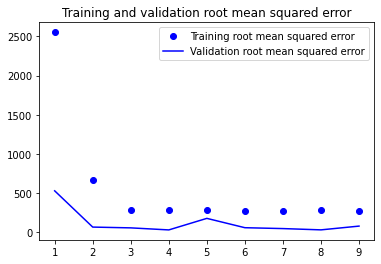

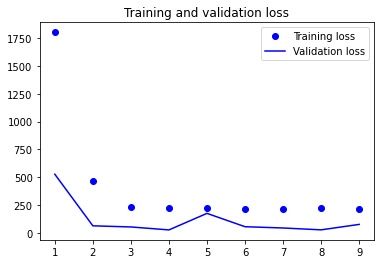

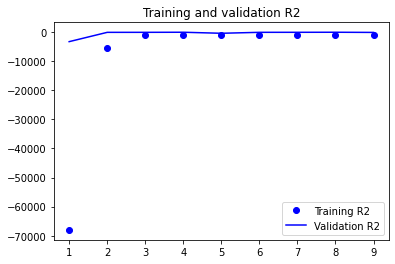

In [ ]:
rmse = history.history['root_mean_squared_error'][1:]
val_rmse = history.history['val_root_mean_squared_error'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
r2 = history.history['coeff_determination'][1:]
val_r2 = history.history['val_coeff_determination'][1:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, rmse, 'bo', label='Training root mean squared error')
plt.plot(epochs, val_rmse, 'b', label='Validation root mean squared error')
plt.title('Training and validation root mean squared error')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.plot(epochs, r2, 'bo', label='Training R2')
plt.plot(epochs, val_r2, 'b', label='Validation R2')
plt.title('Training and validation R2')
plt.legend()
plt.show()



The R2 score is very low. This is a consequence of the high target values. A possible solution to this would be to scale the target value aswell, and then unscale the predicted values later on.

In [ ]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[14.750378608703613, 15.981046676635742, -1.7914668321609497]

In [ ]:
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

24/24 [==============================] - 11s 459ms/step


In [ ]:
test_df['prediction_year'] = pred
test_df[['year', 'prediction_year']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,prediction_year
2324,2017,2000.624268
567,2019,2000.255737
1764,2009,2000.478882
1888,2021,2000.427734
1615,2020,2000.102783
...,...,...
1156,1993,2000.222900
2592,2008,2000.428467
1695,2021,2000.250732
1069,2020,2000.333374


In [ ]:
print('minimum release year predicted: ', test_df['prediction_year'].min())
print('maximum release year predicted: ', test_df['prediction_year'].max())

minimum release year predicted:  1999.7120361328125
maximum release year predicted:  2000.7255859375


The result here reminds us of the result when predicting popularity. The predictions differs very little. 

# Predict length of album name

Now we will use the model to predict the length of the album name. We have a hypothesis that the model will be able to predict the name length better, because several album covers include the album title. 

In [ ]:
df['length_name'] = length
df['year'] = scaled_year

In [ ]:
train_df = df[:(len(df)//4)*3]
test_df = df[(len(df)//4)*3:]

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=None,
  x_col="Image",
  y_col="length_name",
  subset="training",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= None,
  x_col="Image",
  y_col="length_name",
  subset="validation",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory= None,
  x_col="Image",
  y_col=None,
  batch_size=29,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(150,150))

Found 1566 validated image filenames.
Found 522 validated image filenames.
Found 696 validated image filenames.


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
54/54 [==============================] - 35s 652ms/step - loss: 10.9891 - root_mean_squared_error: 17.4878 - coeff_determination: -0.1615 - val_loss: 9.4264 - val_root_mean_squared_error: 14.5630 - val_coeff_determination: -0.0695
Epoch 2/10
54/54 [==============================] - 35s 641ms/step - loss: 10.9016 - root_mean_squared_error: 17.2694 - coeff_determination: -0.1173 - val_loss: 9.4974 - val_root_mean_squared_error: 14.4806 - val_coeff_determination: -0.0766
Epoch 3/10
54/54 [==============================] - 35s 646ms/step - loss: 11.0135 - root_mean_squared_error: 17.2370 - coeff_determination: -0.1232 - val_loss: 9.4729 - val_root_mean_squared_error: 14.5704 - val_coeff_determination: -0.0793
Epoch 4/10
54/54 [==============================] - 35s 641ms/step - loss: 10.9074 - root_mean_squared_error: 17.3693 - coeff_determination: -0.1404 - val_loss: 9.4737 - val_root_mean_squared_error: 14.5707 - val_coeff_determination: -0.0823
Epoch 5/10
54/54 [==============

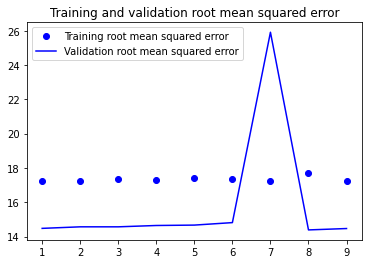

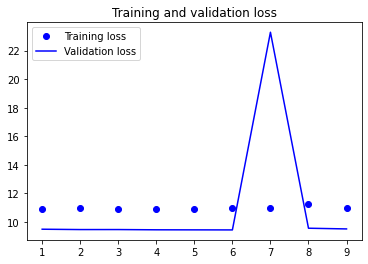

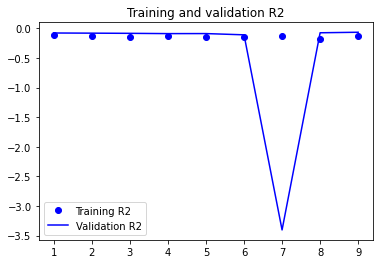

In [ ]:
rmse = history.history['root_mean_squared_error'][1:]
val_rmse = history.history['val_root_mean_squared_error'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
r2 = history.history['coeff_determination'][1:]
val_r2 = history.history['val_coeff_determination'][1:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, rmse, 'bo', label='Training root mean squared error')
plt.plot(epochs, val_rmse, 'b', label='Validation root mean squared error')
plt.title('Training and validation root mean squared error')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.plot(epochs, r2, 'bo', label='Training R2')
plt.plot(epochs, val_r2, 'b', label='Validation R2')
plt.title('Training and validation R2')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID))
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
test_df['prediction_nameLength'] = pred
test_df[['length_name', 'prediction_nameLength']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[9.517535209655762, 14.470890998840332, -0.058445148169994354]
24/24 [==============================] - 11s 463ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,length_name,prediction_nameLength
2324,20,15.328819
567,9,15.354712
1764,24,15.327300
1888,7,15.334263
1615,24,15.344819
...,...,...
1156,14,15.333844
2592,61,15.323298
1695,3,15.342163
1069,8,15.334934


In [ ]:
print('minimum name length predicted: ', test_df['prediction_nameLength'].min())
print('maximum name length predicted: ', test_df['prediction_nameLength'].max())

minimum name length predicted:  15.30578899383545
maximum name length predicted:  15.538005828857422


Disappointingly, the model still gets a negative R2 score. The model fails to predict length of the name precisely, and it differs very little in the predicted values when predicting the length of the name as well. 

# Predict total tracks
Lastly, we will use the model to predict total tracks on the albums. 



In [ ]:
df['total_tracks'] = total_tracks
df['length_name'] = scaled_length

In [ ]:
train_df = df[:(len(df)//4)*3]
test_df = df[(len(df)//4)*3:]

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=None,
  x_col="Image",
  y_col="total_tracks",
  subset="training",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= None,
  x_col="Image",
  y_col="total_tracks",
  subset="validation",
  batch_size=29,
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory= None,
  x_col="Image",
  y_col=None,
  batch_size=29,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(150,150))

Found 1566 validated image filenames.
Found 522 validated image filenames.
Found 696 validated image filenames.


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
54/54 [==============================] - 40s 742ms/step - loss: 5.5062 - root_mean_squared_error: 9.4698 - coeff_determination: -0.0733 - val_loss: 5.6063 - val_root_mean_squared_error: 10.1187 - val_coeff_determination: -0.0992
Epoch 2/10
54/54 [==============================] - 35s 650ms/step - loss: 5.5303 - root_mean_squared_error: 9.5636 - coeff_determination: -0.1067 - val_loss: 5.6669 - val_root_mean_squared_error: 10.2281 - val_coeff_determination: -0.1147
Epoch 3/10
54/54 [==============================] - 35s 651ms/step - loss: 5.4868 - root_mean_squared_error: 9.5348 - coeff_determination: -0.0918 - val_loss: 5.5455 - val_root_mean_squared_error: 9.8996 - val_coeff_determination: -0.0437
Epoch 4/10
54/54 [==============================] - 35s 645ms/step - loss: 5.5077 - root_mean_squared_error: 9.4828 - coeff_determination: -0.0953 - val_loss: 5.5565 - val_root_mean_squared_error: 10.0388 - val_coeff_determination: -0.0701
Epoch 5/10
54/54 [=======================

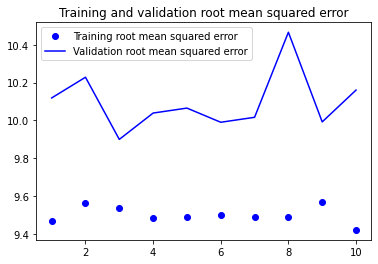

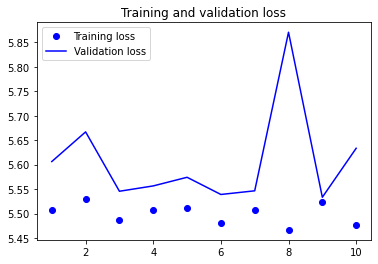

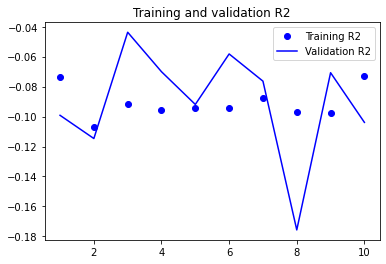

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
r2 = history.history['coeff_determination']
val_r2 = history.history['val_coeff_determination']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, rmse, 'bo', label='Training root mean squared error')
plt.plot(epochs, val_rmse, 'b', label='Validation root mean squared error')
plt.title('Training and validation root mean squared error')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.plot(epochs, r2, 'bo', label='Training R2')
plt.plot(epochs, val_r2, 'b', label='Validation R2')
plt.title('Training and validation R2')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_VALID))
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
test_df['prediction_total_tracks'] = pred
test_df[['total_tracks', 'prediction_total_tracks']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[5.633392810821533, 10.1602201461792, -0.11294600367546082]
24/24 [==============================] - 11s 458ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,total_tracks,prediction_total_tracks
2324,20,11.301080
567,9,10.688635
1764,19,11.452377
1888,14,11.371354
1615,3,11.177458
...,...,...
1156,9,11.375552
2592,21,11.609630
1695,11,11.187872
1069,9,11.384952


In [ ]:
print('minimum total tracks predicted: ', test_df['prediction_total_tracks'].min())
print('maximum total tracks predicted: ', test_df['prediction_total_tracks'].max())

minimum total tracks predicted:  10.280481338500977
maximum total tracks predicted:  11.689360618591309


# Conclusion
The model did not predict any of the features precisely. On all four attempts to predict a feature it got a negative R squared value. The results show that it is not much information to gather from the album covers. This is not surprising. Without any context, the album covers does not offer relevant information. 

The results throughout the exam tells us that popular music is hard to predict from datapoints. From our perspective, this is not unexpected. Popular music can vary a lot. People’s taste of music differs a lot, and music from different genres can be equally popular. This means that predicting an albums popularity from a dataset is hard. We can read from the results that the machine learning models struggles to find a correlation between the data and the popularity of the albums.

#Sources:

Bhaskar, V. (2018). Tutorial on Keras flow_from_dataframe. Tilgjengelig fra: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c. (Hentet: 3. Mai 2022).

Bhaskar, V. (2018). Tutorial on using Keras flow_from_directory and generators. Tilgjengelig fra: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720. (Hentet: 3. Mai 2022).

Jmlb.github. (2017). Implement a Custom Metric Function in Keras. Tilgjengelig fra: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/. (Hentet: 9. Mai 2022)

Kaggle (2021) Music Albums Popularity Prediction. Tilgjengelig fra: https://www.kaggle.com/datasets/elemento/music-albums-popularity-prediction. (Hentet: 7. mars 2022).

Keras. Metrics. Tilgjengelig fra: https://keras.io/api/metrics/. (Hentet: 4. mai 2022).

Lenko, M. (2019) Instructions for transfer learning with pre-trained CNNs.Tilgjengelig fra: https://medium.com/@mikhaillenko/instructions-for-transfer-learning-with-pre-trained-cnns-203ddaefc01. (Hentet: 3. mai 2022).

Müller, A. C. and Guido, S. (2017). Introduction to Machine Learning with Python. Sebastopol, CA 95472: O’Reilly Media, inc.

Poole, D. L. og Mackworth, A. K. (2017) Artificial Intelligence. Cambridge: Cambridge University Press

Rosebrock, A. (2019). Keras, Regression, and CNNs. Tilgjengelig fra: https://pyimagesearch.com/2019/01/28/keras-regression-and-cnns/. (Hentet: 3. Mai 2022)

Sayad, Dr.S. (2022) Support Vector Regression. Tilgjengelig fra: https://www.saedsayad.com/support_vector_machine_reg.htm (Hentet: 12 Mai 2022).

Spotify (2022). Spotify user guidelines. Tilgjengelig fra: https://www.spotify.com/us/legal/user-guidelines/. (Hentet: 5. mai 2022).

Tessem, B. (2022). INFO284 22V / Machine Learning, Lecture Notes. Bergen: https://mitt.uib.no/courses/33150.

Yalçın, O, G. (2020). 4 Pre-Trained CNN Models to Use for Computer Vision with Transfer Learning. Tilgjengelig fra: https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc. (Hentet: 5. Mai 2022).

Xu, S. (2021). VGG19. Tilgjengelig fra: https://www.kaggle.com/code/xushun/vgg19. (Hentet: 6. Mai 2022).

